## Embeddings optimization

We are going to scale the dimension of the embeddings as we believe there might be a network bottleneck as putting all those characters in a 2d space might not be good enough space fot the neurla net to learn it since the loss didnt change much after scaling th ehidden layer size. 

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
with open("names.txt", "r") as file:
    words = file.read().splitlines()

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

In [5]:
def build_dataset(words):
    block_size = 3  # context length: how many characters do we take to predict the next one

    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]    # crop and append

    # basically we have a rolling window for context
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


We will increase the number of of the embeddings dimensions from 2 to 10. 

In [11]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((3*10, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [13]:
print(f"Total num of elements: {sum(p.nelement() for p in parameters)}")

Total num of elements: 11897


In [14]:
for p in parameters:
    p.requires_grad = True

In [16]:
lr = 0.1
lossi = []
stepi = []

In [26]:
for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(
        logits, target=Ytr[ix]
    )  # it can be more numerically well behaved (numerically stable)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    # parameter update
    lr = 0.01

    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr_exponent[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

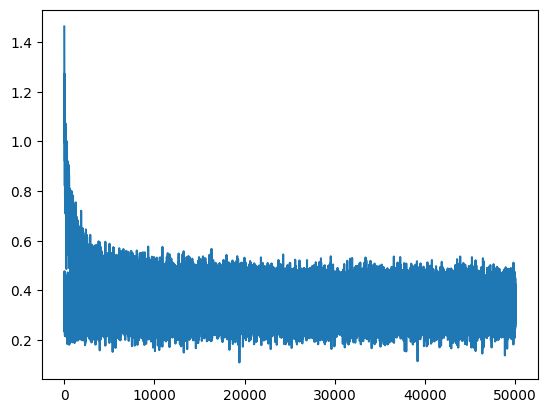

In [27]:
# we want to plot the log loss instead of the loss
# NOTE the loss will have a hockey stick apperance, but the log squashes it; looks nicer
plt.plot(stepi, lossi);

It is again very thick as the minibatch size is very small. 

Both train and val loss are 2.3, decaying the lr by a factor of 10 and is 0.01 now. Rerunning training. 

We hope to beat 2.32 loss. We got a lower loss of 2.1777. We are seing that the losses are deviating and we might have enough parameters to overfit. 

In production, we evaluate during development and only when we are confident that our model is good, we evaluate a single time on the test set and then we brag about it weherever we want (papers or blogs) but you need to say how many times you have run it on your test set. 


Finally we have around 2.16 for train and 2.17 for val/dev set. 


We could play with the size of the embeddings, the neural net or we can increase the numebr of words or in our case characters that the model sees (block size) to further lower the loss. 

In [28]:
# evaluation so to speak. To get the loss on the entire dataset not just the minibatch
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, target=Ytr)    # it can be more numerically well behaved (numerically stable)
loss

tensor(2.1683, grad_fn=<NllLossBackward0>)

In [29]:
# evaluation so to speak. To get the loss on the entire dataset not just the minibatch
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, target=Ydev)    # it can be more numerically well behaved (numerically stable)
loss

tensor(2.1981, grad_fn=<NllLossBackward0>)

TODO: Beat his number of 2.17 on the val set. Also read the paper and try to implement some advices they have for improvement. 